### Since we're running everything on Google's remote servers, we need to re-load all the software packages we'll use each time we open a notebook.

### Please run the following two cells to install all the necessary software. Note that it could take a couple of minutes.

In [ ]:
#STEP 1: Enable the "Anaconda" package manager in this Google Colab Notebook:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
#STEP 2: Install the free SCIP optimization problem solver
!conda install conda-forge::scip

#STEP 3: Download and install my "PyomoTools" package.
#   This will install all other pieces of software we need.
!git clone https://github.com/NathanDavisBarrett/PyomoTools.git
%cd PyomoTools
!pip install .
%cd ..

#At the end of this cell, you'll get a popup window asking you to restart. Please click "cancel".

# Base Retirement Planning Model

$$max \sum_{a \in \textbf{A}} B_{a,t^{END}}$$
$$----\text{ subject to }----$$
$$B_{a,t} = \left(B_{a,t-1}-W_{a,t-1}\right) \times (1 + \delta_a) \ \  \forall a \in \textbf{A}, t \in \textbf{T}^{NON-INIT}$$
$$\sum_{a \in \textbf{A}} W_{a,t} = \omega_t \ \ \forall t \in \textbf{T}$$
$$B_{a,0} = \beta{a} \ \ \forall a \in \textbf{A}$$
$$W_{a,t} \leq 0 \ \ \forall a \in \textbf{A}, t \in \textbf{T}$$

In [166]:
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt

### STEP 1: Define Sets

In [167]:
model = pyo.ConcreteModel()

model.setA = pyo.Set(initialize=["IRA", "401k", "Brokerage"])
model.setT = pyo.Set(initialize=list(range(12 * 25))) #12 months over 25 years

### STEP 2: Define Parameters

In [168]:
alpha = {
    "IRA": 1,
    "401k": 0.8,
    "Brokerage": 0.7
}

beta = {
    "IRA":       300000,
    "401k":      900000,
    "Brokerage":  50000 
}

delta = {
    "IRA": 0.07 / 12,
    "401k": 0.10 / 12,
    "Brokerage": 0.12 / 12
}

omega = {t: 8000*(1+0.02/12)**t for t in model.setT} #"**" means exponent in python

### STEP 3: Define Variables

In [169]:
model.B = pyo.Var(model.setA * model.setT, domain=pyo.NonNegativeReals)
model.W = pyo.Var(model.setA * model.setT, domain=pyo.NonNegativeReals) #I handle the W >= 0 constraint here!

### STEP 4: Define Constraints

In [170]:
model.setT_NON_INIT = pyo.Set(initialize=[t for t in model.setT if t != 0])

def SubsequentBalanceEquation(model,a,t):
    return model.B[a,t] == (model.B[a,t-1]-model.W[a,t-1]) * (1 + delta[a])
model.SubsequentBalanceEquation = pyo.Constraint(model.setA * model.setT_NON_INIT, rule=SubsequentBalanceEquation)

def WithdrawalEnforcement(model,t):
    return sum(alpha[a] * model.W[a,t] for a in model.setA) == omega[t]
model.WithdrawalEnforcement = pyo.Constraint(model.setT,rule=WithdrawalEnforcement)

def InitialBalanceEnforcement(model,a):
    return model.B[a,0] == beta[a]
model.InitialBalanceEnforcement = pyo.Constraint(model.setA,rule=InitialBalanceEnforcement)

### STEP 5: Define Objective

In [171]:
tEnd = np.max(model.setT)
model.Obj = pyo.Objective(expr=sum(model.B[a,tEnd] for a in model.setA), sense=pyo.maximize)

### STEP 6: Solve the Model

In [172]:
solver = pyo.SolverFactory("scip")
solver.solve(model);

### STEP 7: Extract the Results

Here, I want to see two graphs: 1) The balance on each account as a function of time and 2) The amount I withdraw from each account as a function of time.

The details of how I make these graphs are less important. But if you want to make graphs like these, you're welcome to use this a a template.

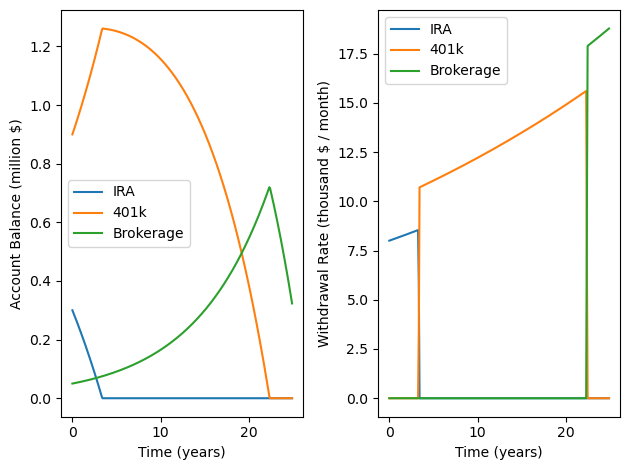

In [173]:
fig,(ax1,ax2) = plt.subplots(1,2)

setT = np.array(model.setT)

#Iterate over each account
for a in model.setA:
    #Collect the balance and withdrawal information for this account.
    balanceHistory = np.array([pyo.value(model.B[a,t]) for t in model.setT])
    withdrawalHistory = np.array([pyo.value(model.W[a,t]) for t in model.setT])

    #Plot this information
    ax1.plot(setT/12,balanceHistory/1000000,label=a)
    ax2.plot(setT[:-1]/12,withdrawalHistory[:-1]/1000,label=a)

#Format the axis labels
ax1.set_xlabel("Time (years)")
ax2.set_xlabel("Time (years)")
ax1.set_ylabel("Account Balance (million $)")
ax2.set_ylabel("Withdrawal Rate (thousand $ / month)")

ax1.legend()
ax2.legend()
fig.tight_layout()